In [1]:
import numpy as np
from scipy.stats import uniform_direction
from distance_debias import Deflation
from distance_debias.utils import get_orthogonal_vec, rs_gaussian, neighborhood_dist_overlap

np.random.seed(42)

# plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams
import matplotlib.ticker as mtick
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 11
rcParams['axes.titlesize'] = 14
rcParams['axes.grid'] =  True
rcParams['grid.alpha'] =  0.3
rcParams['lines.linewidth'] =  2
rcParams['text.latex.preamble'] = r'\newcommand{\bpsi}{\mbox{\boldmath $\psi$}} \newcommand{\peta}{\mbox{\boldmath $\eta$}} \newcommand{\ptheta}{\mbox{\boldmath $\theta$}}'

## 1. Data Simulation
- 1000 data points (n = 1000)
- dimensions m = 10000
- sample theta from Uniform[0, 2$\pi$] and form a circle in 2d
- embed in high D with orthogonal transformation
- sample noise whose noise magnitude is unform from [0, 0.1 + 0.9*(1+np.cos(theta))/2], and direction of noise is uniform

In [2]:
def sample_noise(n,m, theta):
    noise_mag = (0.1 + 0.9*(1+np.cos(2*theta))/2).reshape(-1,1)
    unit_noise_vec = uniform_direction(m).rvs(n)
    return unit_noise_vec * noise_mag

Text(0, 0.5, '$\\textbf{Coordinate 2}$')

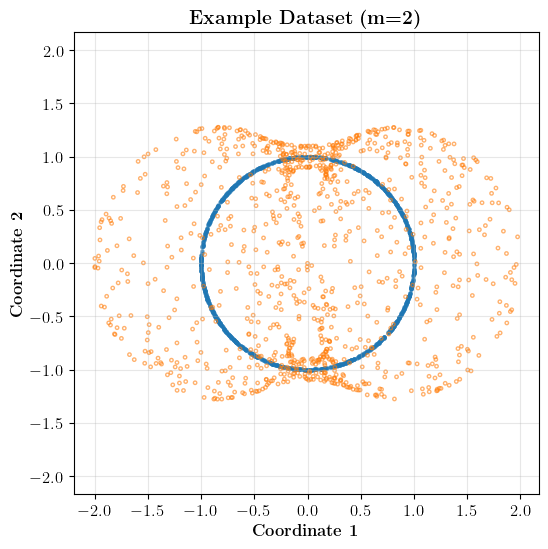

In [3]:
## 2D Example
np.random.seed(42)
n = 1000
theta = np.random.uniform(size = n) *np.pi*2
theta = np.sort(theta, axis = 0)

noise = sample_noise(n,2,theta)
X_2D_clean =  np.column_stack([np.cos(theta),np.sin(theta)])
X_2D_noisy = X_2D_clean + noise

idx = 499
plt.figure(figsize=(6, 6))
plt.scatter(X_2D_clean[:,0], X_2D_clean[:,1], label=r"$\{\mathbf{x}_i\}_{i=1}^n$", c='#1f77b4', s=5, alpha=0.6)
plt.scatter(X_2D_noisy[:,0], X_2D_noisy[:,1], label=r"$\{\mathbf{y}_i\}_{i=1}^n$", 
                 facecolors='none', edgecolors='#ff7f0e', alpha=0.6, s=6)

plt.title(r"\textbf{Example Dataset (m=2)}")
plt.axis('equal')
plt.xlabel(r"$\textbf{Coordinate 1}$")
plt.ylabel(r"$\textbf{Coordinate 2}$");

In [4]:
m = 10000
U_m = get_orthogonal_vec(m, 2)
X_clean = X_2D_clean@U_m.T
noise = sample_noise(n,m, theta)
X_noisy = X_clean + noise

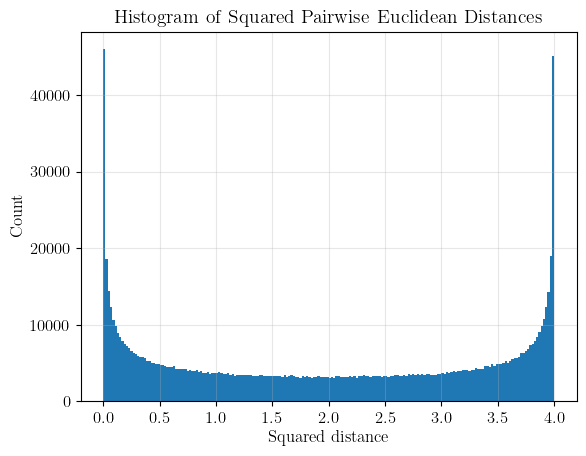

Min Distance:           1.92e-10
5th Percentile:         2.47e-02
10th Percentile:        9.81e-02
25th Percentile:        5.87e-01
Median Distance:        2.00e+00
75th Percentile:        3.42e+00
Max Distance:           4.00e+00


In [5]:
clean_obj = Deflation(X_clean, verbose = True, plot = True, n_jobs = 8)

In [6]:
denoised_obj = Deflation(X_noisy, n_jobs = 8)
denoised_obj.debias_LA()

Min Distance:           1.98e-02
5th Percentile:         3.64e-01
10th Percentile:        7.28e-01
25th Percentile:        1.70e+00
Median Distance:        2.78e+00
75th Percentile:        4.01e+00
Max Distance:           6.21e+00


## 2.Analysis

### 2.1 Noise Magnitude Estimation

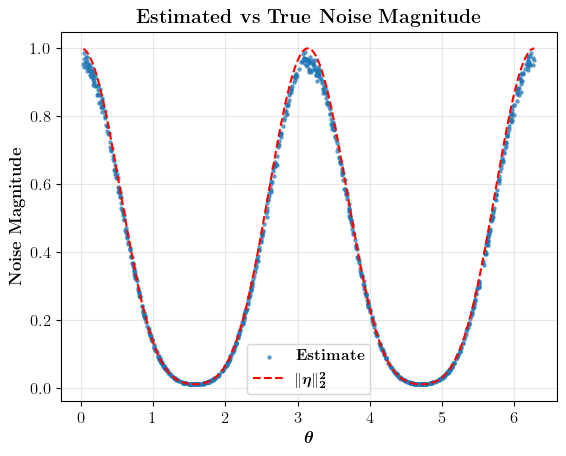

In [7]:
noise_mag = (0.1 + 0.9*(1+np.cos(2*theta))/2).reshape(-1,1)
plt.scatter(theta, denoised_obj.squared_noise_mag, s=5, alpha=0.6, label= r"\textbf{Estimate}")
plt.plot(theta, noise_mag**2, "r--", label=r"$\mathbf{\|\peta\|_2^2}$", linewidth=1.5)
plt.ylabel(r"$\textbf{Noise Magnitude}$")
plt.xlabel(r"$\mathbf{\ptheta}$")
plt.legend()
plt.title(r"\textbf{Estimated vs True Noise Magnitude}");

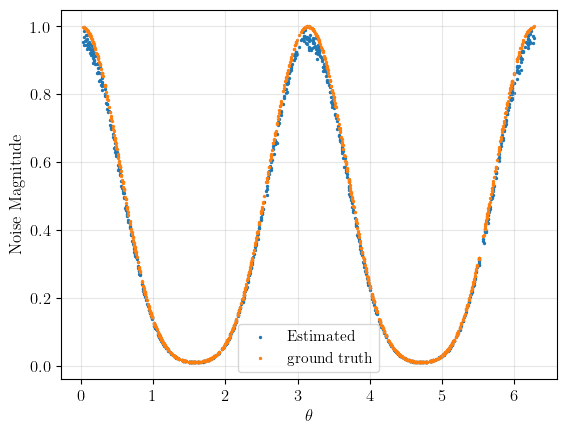

In [8]:
noise_mag = (0.1 + 0.9*(1+np.cos(2*theta))/2).reshape(-1,1)
plt.scatter(theta, denoised_obj.squared_noise_mag, s = 2, label = "Estimated")
plt.scatter(theta, noise_mag**2, s = 2, label = "ground truth")
plt.ylabel("Noise Magnitude")
plt.xlabel(r"$\theta$")
plt.legend()

### 2.2 Signal Noise Ratio

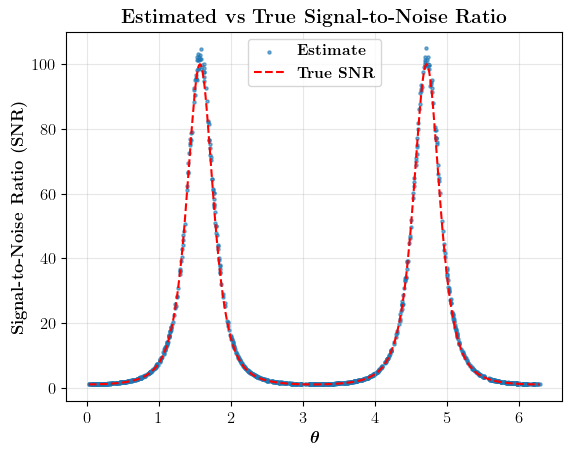

In [9]:
true_sig_mag = np.linalg.norm(X_clean, axis = 1)**2
estimated_sig_mag = np.linalg.norm(X_noisy, axis = 1)**2 - denoised_obj.squared_noise_mag.flatten()

plt.scatter(theta, estimated_sig_mag/denoised_obj.squared_noise_mag.flatten(), 
                 s=5, alpha=0.6, label=r"\textbf{Estimate}")
plt.plot(theta, 1/noise_mag**2, "r--", label=r"\textbf{True SNR}", linewidth=1.5)
plt.ylabel(r"\textbf{Signal-to-Noise Ratio (SNR)")
plt.xlabel(r"$\mathbf{\ptheta}$")
plt.title(r"\textbf{Estimated vs True Signal-to-Noise Ratio}");
plt.legend()

### 2.3 Distance

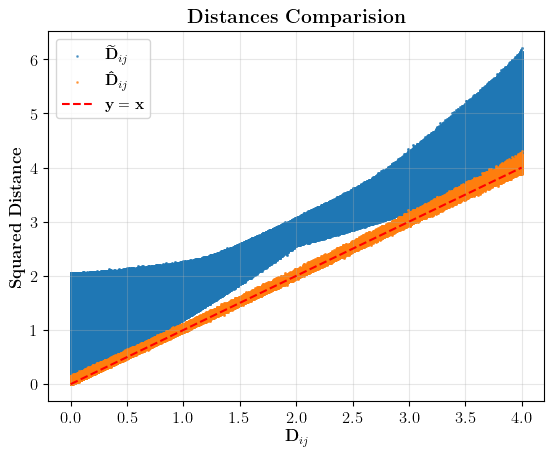

In [10]:
S_distance = clean_obj.S_distance
mask = ~np.isinf(S_distance)
x = np.linspace(np.min(S_distance),np.max(S_distance[mask]), 100)
estimated_S_distance = denoised_obj.denoised
noised_S_distance = denoised_obj.S_distance


plt.scatter(S_distance[mask], noised_S_distance[mask], 
                 label=r"$\widetilde{\mathbf{D}}_{ij}$", s=1, alpha=0.6, rasterized=True)
plt.scatter(S_distance[mask], np.clip(estimated_S_distance[mask], a_min=0, a_max=None),
                 label="$\mathbf{\hat{D}}_{ij}$", s=1, alpha=0.6, rasterized=True)
plt.plot(x, x, "r--", label=r"$\mathbf{y = x}$", linewidth=1.5)

plt.xlabel(r'$\mathbf{D}_{ij}$')
plt.ylabel(r"\textbf{Squared Distance}")
plt.title(r"\textbf{Distances Comparision}");
plt.legend()

### 2.4 Affinity

In [11]:
## Gaussian Kernel
bd = 0.5
noise_aff = rs_gaussian(denoised_obj.S_distance, bd)
denoised_aff = rs_gaussian(denoised_obj.denoised, bd)
clean_aff = rs_gaussian(clean_obj.S_distance, bd)

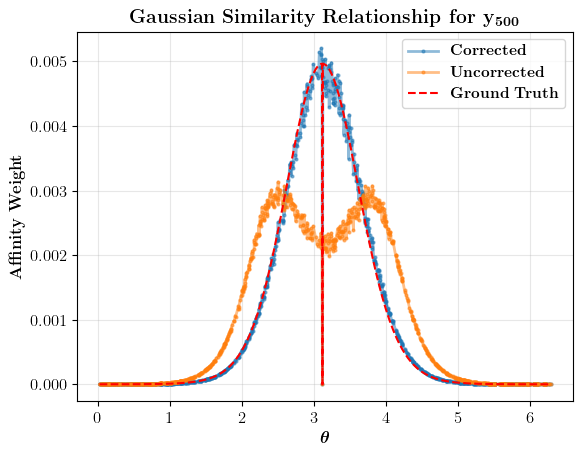

In [12]:
row_idx = 499

plt.plot(theta, denoised_aff[row_idx,:], "o-", label= r"\textbf{Corrected}", 
               markersize=2, alpha=0.5)
plt.plot(theta, noise_aff[row_idx,:], "o-", label= r"\textbf{Uncorrected}", 
               markersize=2, alpha=0.5)
plt.plot(theta, clean_aff[row_idx,:], "r--", label= r"\textbf{Ground Truth}", linewidth=1.5)

plt.xlabel(r"$\mathbf{\ptheta}$")
plt.ylabel(r"\textbf{Affinity Weight}")
plt.title(r"$\textbf{Gaussian Similarity Relationship for }\mathbf{y_{500}}$")
plt.legend()

### 2.5 near neighbor detection

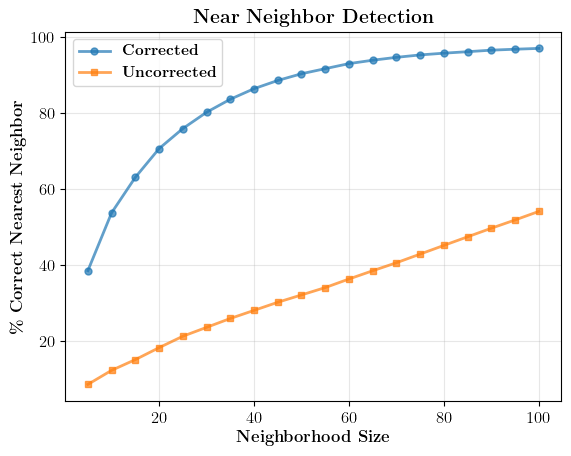

In [13]:
denoised_rate = []
noisy_rate = []
for k in range(5, 101, 5):
    denoised_r, noisy_r = neighborhood_dist_overlap(S_distance, estimated_S_distance, noised_S_distance, k)
    denoised_rate.append(denoised_r)
    noisy_rate.append(noisy_r)

plt.plot(range(5,101,5), 100*np.array(denoised_rate), 'o-',label=r"\textbf{Corrected}", 
                 markersize =5, alpha=0.7, )
plt.plot(range(5, 101, 5), 100*np.array(noisy_rate), 's-', label=r"\textbf{Uncorrected}", 
                 markersize=5, alpha=0.7, )
plt.xlabel(r"\textbf{Neighborhood Size}")
plt.ylabel(r"\textbf{\% Correct Nearest Neighbor}")
plt.title(r"\textbf{Near Neighbor Detection}")
plt.legend()